# TRP FAQ chatbot using pretrained Google News Word2Vec Model -
run on Python 3 Environment

Importing necessary libraries

In [200]:
import os 
import numpy as np
import pandas as pd
import re, unicodedata
import string
import pickle
from nltk import sent_tokenize, word_tokenize

In [201]:
os.chdir('C:/Users/akadali/Desktop/Deep_NLP/MLG_Capstone_ChatBot/ChatBot_GoogleW2V')
data = pd.read_csv('chatbot_train.csv', encoding = 'latin1')
data = data[['question', 'answer', 'intent']]

Importing stop words, WordNetLemmatizer and punctuations

Data Cleaning
-----

* This dataset has a lot of contractions, hence all of them need to be removed/replaced within the dataset. The below function replaces the contractions with corresponding word pairs.

* Also, there are quite a few abbreviations such as U.S., US, USI to be substituted with their expanded forms

* removing additional spaces, if there are any

In [202]:
import nltk
stops = nltk.corpus.stopwords.words('english')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import string
puncs = string.punctuation
#Adding additional punctuations
puncs = puncs + "’'`" 
print(puncs)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~’'`


In [203]:
import re
def text_clean(text):
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('[%s]'%re.escape(puncs), ' ', text)
    #convert u.s or us  to 'United States'
    text = re.sub(r" U.S. ", " united states ", text)
    text = re.sub(r" US ", " united states ", text)
    text = re.sub(r" USI ", " united states india ", text)
    text = re.sub(r" +"," ", text)
    #Removing additional characters that captured during import
    text = re.sub("[\x97]","'", text)
    text = re.sub("[\x96]","'", text)
    text = re.sub("[\x95]","'", text)
    text = re.sub("[\x94]","'", text)
    text = re.sub("[\x93]","'", text)
    text = re.sub("[\x92]","'", text)
    text = re.sub("[\x91]","'", text)
    return text

Data Preprocessing and Cleaning(2)
----------------------------
* Tokenizing the words
* Lemmatization
* removing numeric digits and punctuations

In [204]:
def text_preprocess(text):
    #tokenizing
    tokens = word_tokenize(text)
    #converting to lower case and lemmatization
    #tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens]
    tokens = [word.lower() for word in tokens]
    filtered_tokens = []
    #Remove anything but alphabets - numbers, punctuations etc
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    #return list of lists for embedding vectors
    return filtered_tokens

#### Applying 'Cleaning' and 'Preprocessing' methods on the dataset

In [205]:
#Clean the questions dataset
data['question'] = data['question'].apply(lambda x:text_clean(x))

In [206]:
#Preprocess the questions
data['question'] = data['question'].apply(lambda x:text_preprocess(x))

In [182]:
#Preprocess the questions except the ones with greeting 
#for i in range(len(data)):
#    if data['intent'].iloc[i] != 'greeting':
#        data['question2'].iloc[i] = text_preprocess(str(" ".join(data['question2'].iloc[i])))

Pre-trained word and phrase vectors from gensim models
-----------------------------------------
* Getting GoogleNews-vectors-negative - A Pre-trained word and phrase vectors. 'Questions'in our dataset are converted to vectors by averaging the vectors of individual words in each question.

* This can be loaded using 'gensim.models'

In [150]:
import gensim.models
#Changing the directory to get to the embeddings 
os.chdir('C:/Users/akadali/Desktop/Deep_NLP/MLG_Capstone_ChatBot/ChatBot_GoogleW2V/Word Embeddings')
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

Below function creates the 300-dimension vectors for each question (for all tokens that are present in the Google New pre-trained Word2Vec models)

In [207]:
# Creating a feature vector by averaging embeddings for all words in a sentence
def embedding_feats(list_of_tokens):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    #feats = []
    feat_for_this = zero_vector
    count_for_this = 0
    for token in list_of_tokens:
        if token in model:
            feat_for_this += model[token]
            count_for_this+= 1
    feats = feat_for_this/count_for_this
    return feats

Creating vectors for all questions in the faq dataset

In [208]:
#np.seterr(divide='ignore', invalid='ignore')
question_vectors = [embedding_feats(x) for x in data['question']]

# Estalishing connection to the 'Talent referral payout' database in SQL
* Establish connection with the TRP databases (both payout and referral databases) in SQL Workbench
* Write functions to retrieve the data based on user request.

In [124]:
import mysql.connector
mydb = mysql.connector.connect(host="localhost", 
                               user="root", 
                               passwd="root",
                               auth_plugin = 'mysql_native_password',
                               database = "talent_referral_payout")

In [125]:
mycursor = mydb.cursor(buffered = True)

In [126]:
#Definition to obtain te referral bonus payout history of a referring professional

def search_pay_db(emp_id):
    emp_id = str(emp_id)
    #print(type(emp_id))
    query = "SELECT referral_name,amount,date_of_origin FROM trp_payment_report_sample WHERE emp_num = "+ emp_id
    mycursor.execute(query)
    return mycursor.fetchone()

In [127]:
#Definition to obtain the status of referrals submitted by the referring professional

def search_status_db(rms_id):
    rms_id = str(rms_id)
    #print(type(emp_id))
    query = "SELECT candidate_name,requisition_no,current_status,reference_date FROM trp_status WHERE candidate_id = " + rms_id
    mycursor.execute(query)
    return mycursor.fetchone()

* This block of code would convert the user's question to a 300 dimensional vector and calculates the cosine_similarity against all question vectors in the FAQ dataset. 
* Obtains the correspoding answer of the best matched question

In [128]:
from sklearn.metrics.pairwise import cosine_similarity

def get_response(t):
    #print(query)
    while True:
        user_input = input("You:")
        if len(user_input) == 0:
            print("Bot: Can you please provide more information")
        elif user_input.lower() == 'referral_bonus':
            print("Enter your personnel number to fetch the payment details")
            emp_no = input("Emp. ID:")
            emp_no = str(emp_no)
            ans = search_pay_db(emp_no)
            print("Bot: Your bonus payout details are below (in the last 6 months)")
            print("Bot:", ans)
            print("Bot: Let me know if I can help you with anything else")
        elif user_input.lower() == 'referral_status':
            print("Bot: Enter your referral's RMS/Taleo ID to fetch the status info.")
            email = input("ID:")
            email = str(email)
            ans = search_status_db(email)
            print("Bot: Below are the list of referrals you submitted in the last 6 months")
            print("Bot:", ans)
            print("Bot: Let me know if I can help you with anything else")
        elif user_input.lower() == 'quit':
            break
        else:
            q = text_clean(user_input)
            q = text_preprocess(user_input)
            q_vec = [embedding_feats(q)]
            sims = cosine_similarity(q_vec, question_vectors)
            max_s = sims.max()
            if max_s < t:
                response = "Hmm..sorry, I don't quite understand that, can you please rephrase your question"
            else:
                max_i = np.argmax(sims)
                response = data.answer[max_i]
            print("Bot:", response)

In [129]:
"""
def chat():
    print("Specify the confidence level")
    level = input("Confidence:")
    conf = int(level)/100
    print("Hi There....I'm Talent Referral Bot and I'm here to help you with referral inquiries\n[type 'quit' to stop]")
    print("***TIP: PLEASE ENTER \n 1.'referral_status' -> to check your referral status \n 2.'referral_bonus' -> to check your bonus payout status and \n 3.'program' -> for program related inquiry")
    while True:
        user_input = input("You:")
        if user_input.lower() == 'quit':
            break
        if user_input == '':
            print("Bot: Can you please provide more information")
        elif user_input.lower() == 'referral_bonus':
            print("can you please provide your personnel employee number")
            emp_no = input("Emp. ID:")
            emp_no = str(emp_no)
            ans = search_pay_db(emp_no)
            print("Bot: Please find your bonus payout details below (in the last 6 months)")
            print("Bot:", ans)
        elif user_input.lower() == 'referral_status':
            print("can you please provide your referral's personal email adress to fetch the status info.")
            email = input("Email:")
            email = str(email)
            ans = search_status_db(email)
            print("Bot: Please find the status of your referrals(in the last 6 months)")
            print("Bot:",ans)
        elif user_input.lower() == 'program':
            print("Bot: Please enter your question here\n (type 'quit' to stop)")
            while True:
                user_input = input("You:")
                if user_input.lower() == 'quit':
                    break
                ans = get_response(user_input, conf)
                print("Bot:", ans)
"""

'\ndef chat():\n    print("Specify the confidence level")\n    level = input("Confidence:")\n    conf = int(level)/100\n    print("Hi There....I\'m Talent Referral Bot and I\'m here to help you with referral inquiries\n[type \'quit\' to stop]")\n    print("***TIP: PLEASE ENTER \n 1.\'referral_status\' -> to check your referral status \n 2.\'referral_bonus\' -> to check your bonus payout status and \n 3.\'program\' -> for program related inquiry")\n    while True:\n        user_input = input("You:")\n        if user_input.lower() == \'quit\':\n            break\n        if user_input == \'\':\n            print("Bot: Can you please provide more information")\n        elif user_input.lower() == \'referral_bonus\':\n            print("can you please provide your personnel employee number")\n            emp_no = input("Emp. ID:")\n            emp_no = str(emp_no)\n            ans = search_pay_db(emp_no)\n            print("Bot: Please find your bonus payout details below (in the last 6 mon

In [130]:
def chat_test():
    print("Specify the confidence level")
    level = input("Confidence:")
    conf = int(level)/100
    print("Hi There....I'm Talent Referral Bot and I'm here to help you with referral inquiries\n[type 'quit' to stop]")
    print("***TIP: PLEASE ENTER \n 1.'referral_status' -> to check your referral status \n 2.'referral_bonus' -> to check your bonus payout status and \n 3.'program' -> for program related inquiry")
    ans = get_response(conf)
    #print("Bot:", ans)

In [131]:
chat_test()

Specify the confidence level
Confidence:80
Hi There....I'm Talent Referral Bot and I'm here to help you with referral inquiries
[type 'quit' to stop]
***TIP: PLEASE ENTER 
 1.'referral_status' -> to check your referral status 
 2.'referral_bonus' -> to check your bonus payout status and 
 3.'program' -> for program related inquiry
You:quit


# Testing with test_data

In [209]:
#Testing the Chabot with Test Dataset
os.chdir('C:\\Users\\akadali\\Desktop\\Deep_NLP\\MLG_Capstone_ChatBot\\ChatBot_GoogleW2V')

#importing test dataset
test_data = pd.read_csv("chatbot_test.csv", encoding = 'latin1')

In [210]:
#test_data.drop(['Unnamed: 3'], axis = 1, inplace = True)
def test_response(q, vecs = question_vectors):
    q = text_clean(q)
    q = text_preprocess(q)
    q_vec = [embedding_feats(q)]
    sims = cosine_similarity(q_vec, vecs)
    max_s = sims.max()
    max_i = np.argmax(sims)
    train_q = " ".join(data.question[max_i])
    return max_s, data.answer[max_i], train_q, data.intent[max_i]

test_data['bot_response'] = test_data['test_question'].apply(lambda x:test_response(x)[1])
test_data['train_question'] = test_data['test_question'].apply(lambda x:test_response(x)[2])
test_data['sim_score'] = test_data['test_question'].apply(lambda x:test_response(x)[0])
test_data['train_intent'] = test_data['test_question'].apply(lambda x:test_response(x)[3])

test_data['valid'] = test_data['intent'] == test_data['train_intent']

print("Accuracy of Google W2v \n",(test_data.valid.sum()/len(test_data)).round(2))
print("Average Simailarity score",test_data.sim_score.mean())

##First Test result with stop words
# Accuracy - 31%
# Mean Similarity score - 0.74

##Second Test Result - with stop words
# Accuracy - 48%
# Mean Similarity score - 0.89

##Third Test Result - without stop words
# Accuracy - 2%
# Mean Similarity score - 0.40

##Fourth Test Result - with stop words and without lemmatization
# Accuracy - 54%
# Mean Similarity score - 0.89


##Fifth Test Result - with stop words, without lemmatization, Intent standardization
# Accuracy - 66%
# Mean Similarity score - 0.89



Accuracy of Google W2v 
 0.66
Average Simailarity score 0.8967927026869852


In [ ]:
##First Test result with stop words
# Accuracy - 31%
# Mean Similarity score - 0.88


##Second Test Result - with stop words
# Accuracy - 48%
# Mean Similarity score - 0.89


##Third Test Result - without stop words
# Accuracy - 2%
# Mean Similarity score - 0.40

##Fourth Test Result - with stop words and without lemmatization
# Accuracy - 54%
# Mean Similarity score - 0.89

##Fifth Test Result - with stop words, without lemmatization, Intent standardization
# Accuracy - 66%
# Mean Similarity score - 0.89


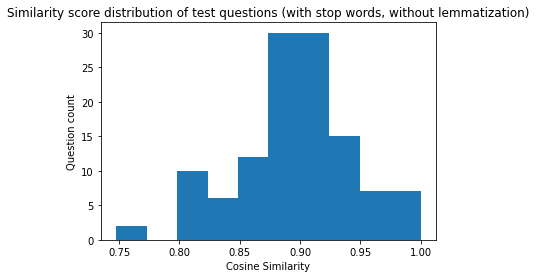

In [211]:
import matplotlib.pyplot as plt
plt.title("Similarity score distribution of test questions (with stop words, without lemmatization)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Question count")
plt.hist(test_data.sim_score)
plt.show()

In [ ]:
#question = "Can you advise me on when I will receive it and the amount."
#test_response(question)

In [155]:
test_data.to_csv("C:\\Users\\akadali\\Desktop\\Deep_NLP\\MLG_Capstone_ChatBot\\ChatBot_GoogleW2V\\test_results_w2v.csv",
                 index = False, header = True)

In [ ]:
#Sample RMS IDs for chatbot testing of referral status
"""
24211419
18327009
24482992
21996054
22425736
24426987
17783534
24601097
23736632
24698456
24623156
21705392
"""
#Sample Employee IDs for chatbot testing bonus status
"""
213408
239660
249058
250194
260943
271637
274346
282822
284183
284315
284754
285695
290560
"""

# Methods for Chatbot GUI response 

In [472]:
def gui_response(user_input):
    user_input = str(user_input)
    if len(user_input) == 0:
        response = "Looks like you have not asked any question. Please feel free to ask me anything related to referral program."
    else:
        user_input = text_clean(user_input)
        user_input = text_preprocess(user_input)
        q_vec = [embedding_feats(user_input)]
        sims = cosine_similarity(q_vec, question_vectors)
        max_s = sims.max()
        if max_s < 0.6:
            response = "I'm sorry, I don't think I understood that correctly, can you please rephrase your question and try again.Feel free to email ustalentreferralprogram@deloitte.com to reach referral team, if I’m not able to solve your problem right now"
        else:
            max_i = np.argmax(sims)
            response = data.answer[max_i]
    return response

In [473]:
def gui_bonus(emp_id):
    emp_id = str(emp_id)
    ans = search_pay_db(emp_id) 
    if ans is not None:
        res = "You were paid $"+ str(ans[1])+" for referring "+str(ans[0])+" along with "+str(ans[2])+" pay period"
    else:
        res = "Sorry, I couldn't find any result with the input provided" 
    return res

In [474]:
def gui_status(rms_id):
    rms_id = str(rms_id)
    ans = search_status_db(rms_id)
    if ans is not None:
        res = "Your referral "+str(ans[0])+ " has been "+str(ans[2])+" for requisition with ID:"+str(ans[1])
    else:
        res = "Sorry, I couldn't find any result with the input provided" 
    return res

# Creating Chatbot GUI using tkinter updated ao 09/16/2020

In [829]:
import os
os.chdir("C:\\Users\\akadali\\Desktop\\Deep_NLP\\MLG_Capstone_ChatBot\\ChatBot_GoogleW2V")

In [97]:
#Importing tkinter
import tkinter
from tkinter import *

In [98]:
#Enabling High DPI in Windows 10
try:
    from ctypes import windll
    windll.shcore.SetProcessDpiAwareness(1)
except:
    pass

In [99]:
def send(*args):
    msg = messageWindow.get("1.0",'end-1c')
    messageWindow.delete("0.0",END)
    if msg == '':
        chatWindow.config(state=NORMAL)
        chatWindow.insert(END, "You: \n" + msg + '\n')
        chatWindow.config(foreground="#3b5998", font=("Helvetica Neue", 9, 'bold' ))
        res = "Please feel free to ask me anything related to referral program."
        chatWindow.insert(END, "Bot: " + res + '\n\n')
        chatWindow.config(state=DISABLED)
        chatWindow.yview(END)
    else: 
        chatWindow.config(state=NORMAL)
        chatWindow.insert(END, "You: " + msg + '\n')
        chatWindow.config(foreground="#3b5998", font=("Helvetica Neue", 9, 'bold' ))
        res = gui_response(msg)
        chatWindow.insert(END, "Bot: " + res + '\n\n')
        chatWindow.config(state=DISABLED)
        chatWindow.yview(END)

In [100]:
def bonus():
    pers = messageWindow.get("1.0",'end-1c')
    messageWindow.delete("0.0",END)
    if pers == '':
        chatWindow.config(state=NORMAL)
        #chatWindow.insert(END, "You: " + msg + '\n')
        chatWindow.config(foreground="#3b5998", font=("Helvetica Neue", 9, 'bold' ))
        res = "Please enter your Personal Emp.ID and click on 'Bonus History' again"
        chatWindow.insert(END, "Bot: " + res + '\n\n')
        chatWindow.config(state=DISABLED)
        chatWindow.yview(END)
    else:
        chatWindow.config(state=NORMAL)
        chatWindow.insert(END, "Your Emp ID: " + pers + '\n\n')
        chatWindow.config(foreground="#3b5998", font=("Helvetica Neue", 9, 'bold' ))
        res = gui_bonus(pers)
        chatWindow.insert(END, "Bot: " + res + '\n\n')
        chatWindow.config(state=DISABLED)
        chatWindow.yview(END)

In [101]:
def status():
    rms_id = messageWindow.get("1.0",'end-1c')
    messageWindow.delete("0.0",END)
    if rms_id == '':
        chatWindow.config(state=NORMAL)
        #chatWindow.insert(END, "You: " + msg + '\n')
        chatWindow.config(foreground="#3b5998", font=("Helvetica Neue", 9, 'bold' ))
        res = "Please enter your referral's RMS.ID and click on 'Referral Status' again"
        chatWindow.insert(END, "Bot: " + res + '\n\n')
        chatWindow.config(state=DISABLED)
        chatWindow.yview(END)
    else:
        chatWindow.config(state=NORMAL)
        chatWindow.insert(END, "Candidate RMS ID: " + rms_id + '\n\n')
        chatWindow.config(foreground="#3b5998", font=("Helvetica Neue", 9, 'bold' ))
        res = gui_status(rms_id)
        chatWindow.insert(END, "Bot: " + res + '\n\n')
        chatWindow.config(state=DISABLED)
        chatWindow.yview(END)

In [102]:
def quick_help():
    chatWindow.config(state=NORMAL)
    chatWindow.config(foreground="#3b5998", font=("Helvetica Neue", 9, 'bold'))
    res = "Hi there! Here are a few options for your quick help \n ----------------------------------------------------------------------------------------- \n -> Internship Referrals                                    - Type 'Intern'  \n ----------------------------------------------------------------------------------------- \n -> Cannot upload Resume                               - Type 'resume'   \n ----------------------------------------------------------------------------------------- \n -> Cannot access referral page                       - Type 'technical'\n ----------------------------------------------------------------------------------------- \n -> Position not found/No 'refer a friend' link - Type 'job'     \n----------------------------------------------------------------------------------------- \n-> Need 'Referral submission' link                   - Type 'link'     \n----------------------------------------------------------------------------------------- \n-> Bonus not received                                       - Type 'Bonus'    \n----------------------------------------------------------------------------------------- \n-> 'Client' Referrals                                            - Type 'client'   \n ----------------------------------------------------------------------------------------- \n Bot: Have a different query??..please feel free to type your question here"
    chatWindow.insert(END, "Bot: " + res + '\n\n')
    chatWindow.config(state=DISABLED)
    chatWindow.yview(END)

In [103]:
root = Tk()
root.title("TRP_ChatBot BETA")
root.geometry("600x700")
root.resizable(width = FALSE, height = FALSE)

''

In [104]:
#Message header of the chatbot

message = "Referral Program ChatBot"
msg1 = tkinter.Message(root, text = message)
msg1.config(bg="#3b5998", fg="snow", font=('Helvetica Neue', 14, 'bold'), justify = RIGHT , width = "700")
msg1.place(x=0, y=0, height = 32, width = 600)

In [105]:
message = "- Get your referral inquiries answered here -"
msg1 = tkinter.Message(root, text = message)
msg1.config(bg="#3b5998", fg="snow", font=('Helvetica Neue', 8, 'italic'), justify = CENTER , width = "700")
msg1.place(x=0, y=32, height = 18, width = 600)

In [106]:
#Create Chat Window

chatWindow = Text(root, bd=1, bg="grey93",  width="50", height="8", font=("Helvetica Neue", 12), foreground="grey7")
#message3 = "Hello There....what can I help you with today?"
#msg3 = tkinter.Message(chatWindow, text = message3)
#photo = PhotoImage(file='./ipad_image.png')
#chatWindow.image_create(END, image=photo)
#chatWindow.tag_config(root, background="yellow")
chatWindow.place(x=0,y=50, height=500, width=585)

In [107]:
#Bind scrollbar to Chat window

scrollbar = Scrollbar(root, command=chatWindow.yview, cursor="clock")
scrollbar.place(x= 585,y = 50, height=500)
chatWindow['yscrollcommand'] = scrollbar.set

In [108]:
#Create Buttons

#login_btn = PhotoImage(file = 'login.png')

Button1= Button(root, text = "Enter >",  width="12", height=5, bd=0, bg="#4267B2", activebackground="#dfe3ee", 
                foreground='#ffffff',font=("Helvetica Neue", 12,'bold'), command = send, borderwidth = 3)
Button1.place(x=500, y=572, height=128, width = 100)


Button4= Button(root, text="Quick help",width="12", height=5, bd=0, bg="#4267B2", 
                activebackground="#dfe3ee", foreground='#ffffff',font=("Helvetica Neue", 10,'bold'), 
                borderwidth = 2, command = quick_help)
Button4.place(x=0, y=522, height=30, width = 200)


Button2= Button(root, text="Referral status", width="12", height=5, bd=0, bg="#4267B2", 
                activebackground="#dfe3ee", foreground='#ffffff',font=("Helvetica Neue", 10,'bold'), 
                borderwidth = 2, command = status)
Button2.place(x=400, y=522, height=30, width = 200)


Button3= Button(root, text="My bonus history", width="12", height=5, bd=0, bg="#4267B2", 
                activebackground="#dfe3ee", foreground='#ffffff',font=("Helvetica Neue", 10, 'bold'), 
                borderwidth = 2, command = bonus)
Button3.place(x=200, y=522, height=30, width = 200)

In [109]:
#Message header for the message window

message2 = "Enter your questions below..."
msg2 = tkinter.Message(root, text = message2)
msg2.config(bg="#8b9dc3", fg="snow", font=('Calibri', 9, 'italic'), justify = LEFT, width = "366")
msg2.place(x=0, y= 552, height= 20, width = 600)

In [110]:
#Create Message Window

messageWindow = Text(root, bd=0, bg="grey99",width="30", height="4", font=("Helvetica Neue", 10), foreground="grey7")
#messageWindow.insert(END, "Please enter your queries here...")
#messageWindow.delete("0.0",END)
messageWindow.place(x=7, y=579, height=113, width=486)

In [111]:
#Assigning shortcuts and key-bidings to the buttons

root.bind("<Return>",send)
root.bind("<KP_Enter>",send)

'2325802185416send'

In [112]:
root.mainloop()